In [1]:
import pickle
from copy import deepcopy

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import numpy as np; np.set_printoptions(suppress=True, linewidth=180)
import pandas as pd; pd.set_option('display.width', 500)
import matplotlib.pyplot as plt

from scipy.optimize import minimize


from plot_module import plot_ODE, plot_gillespie, plot_simulator_graph, plot_neuron_graph
from sim_param_from_network import names_from_network, gillespie_param_from_network, dataframes_from_network, ODE_from_network, start_state_from_nodes
from neuron_graph_transform import neuron_graph_transform
from neuron_graph_bioparam import add_bioparam_attributes, calculate_influx_efflux ,calculate_target_nss 


from simulate import simulate_ode, simulate_gillespie
from graph_flow_solve import solve_subgraph_flux

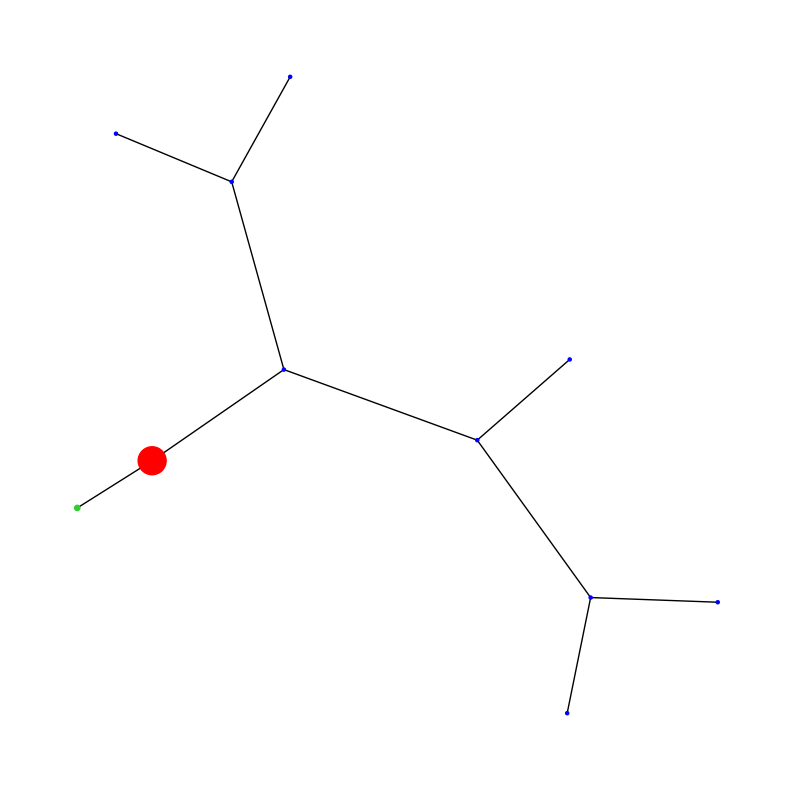

In [2]:
#neuron_filename = 'h_cerebellum_interneuron_NMO_32551'
neuron_filename = 'm_hippocampus_NMO_97827'
with open(f'neuron_shape_data/{neuron_filename}.pkl', 'rb') as f:
    imported_neuron_graph = pickle.load(f)    
#G_raw.remove_node('319')

plot_neuron_graph(imported_neuron_graph)

In [3]:
DELTA = 0.5
DEATH_RATE = 0.4
SWITCH_RATE_AR = 0.01
SWITCH_RATE_RA = 0.01

TRANSP_SPEED = 14000

SOMA_CB = 1.0
SOMA_BR = 3.2
SOMA_NSS = 500
SOMA_DIFFUSION = 0.4
SOMA_MITO_DENSITY = 2 # number of mt/um^3 of volume


AXON_MITO_DENSITY = 2 # number of mt/um^3 of volume
AXON_TRNSP_ANT = 8
AXON_TRNSP_RET = 6

# AXON_TERMINAL_INFLUX = 2*DEATH_RATE*AXON_NODE_POP
# AXON_TERMINAL_EFFLUX = DEATH_RATE*AXON_NODE_POP


DENDRITE_MITO_DENSITY = 2 # number of mt/um^3 of volume

bio_param = {
    # global parameters    
    'delta': DELTA, 
    'switch_rate_ar': SWITCH_RATE_AR,
    'switch_rate_ra': SWITCH_RATE_RA,
    
    # soma parameters
    'soma_death_rate': DEATH_RATE, 
    'soma_mito_density': SOMA_MITO_DENSITY,
    'soma_cb': SOMA_CB, 
    'soma_br': SOMA_BR, 
    'soma_diffusion': SOMA_DIFFUSION,
    'soma_nss': None,
    
    # axon parameters
    'axon_death_rate': DEATH_RATE, 
    'axon_mito_density':AXON_MITO_DENSITY,
    'axon_nss': None,
    'axon_transp_speed': TRANSP_SPEED,
    'axon_terminal_influx': None,
    'axon_terminal_efflux': None,

    # dendrite paramters
    'dendrite_death_rate': DEATH_RATE, 
    'dendrite_mito_density': SOMA_MITO_DENSITY,
    'dendrite_nss': None,
    'dendrite_transp_speed': TRANSP_SPEED,
    'dendrite_terminal_influx': None,
    'dendrite_terminal_efflux': None,
    }




> Inferring target node populations per branch type from section volumes.
total soma volume is 278.06 µm^3 spread across 1 node(s). At a density of 2 mt/µm^3, this gives a target pop. of 556 mt/node
total axon volume is 4.36 µm^3 spread across 9 node(s). At a density of 2 mt/µm^3, this gives a target pop. of 1 mt/node
total dendrite volume is 3.95 µm^3 spread across 1 node(s). At a density of 2 mt/µm^3, this gives a target pop. of 8 mt/node

> Inferring net influx and efflux at at axon and dendrite terminals.
at a death rate of 0.4, a target axon pop. of 1, requires an influx of 0.8 mt and an outflow of 0.4 mt
at a death rate of 0.4, a target dendrite pop. of 8, requires an influx of 6.4 mt and an outflow of 3.2 mt

>> Transforming input graph:
> The undirected input graph has 11 nodes, and 10 edges. Found 2 branches:
axon of 9 nodes, total volume is 4.36 um^3
dendrite of 1 nodes, total volume is 3.95 um^3
> the directed output graph has 11 nodes, and 20 edges

>> Adding biological pa

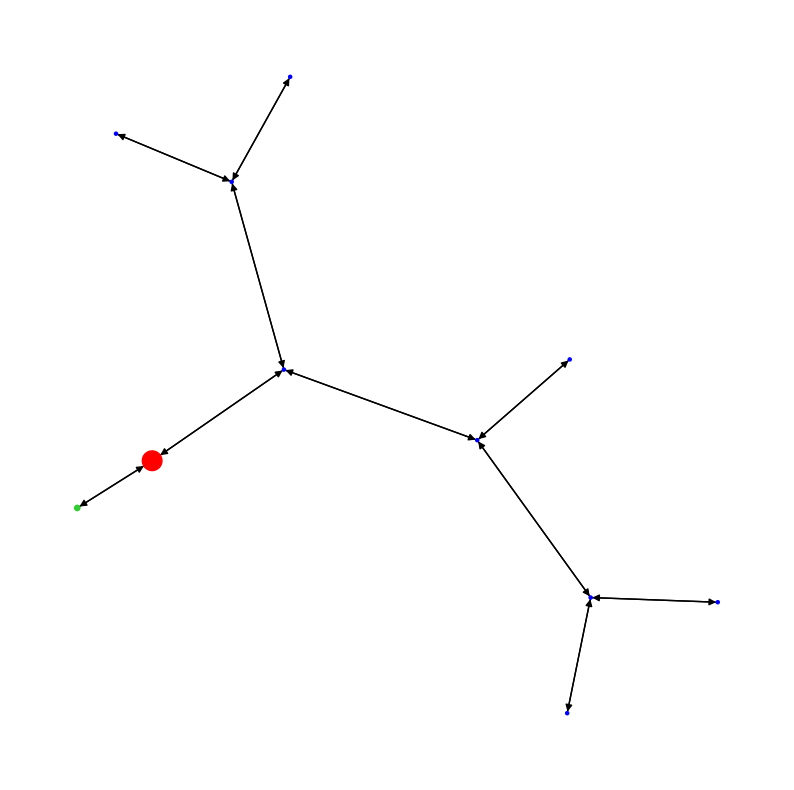

In [4]:
# calculate the target nss values, based on the mitochondrial densities, volumes, and node counts of each respective section
bio_param = calculate_target_nss(imported_neuron_graph, bio_param)
# calculate the target net influx and efflux at axon and soma terminals
bio_param = calculate_influx_efflux(imported_neuron_graph, bio_param)

# transform the graph 
G, G_subgraphs = neuron_graph_transform(imported_neuron_graph, transform_type='bidirect', n_soma_nodes=1)

# add biological parameters
G = add_bioparam_attributes(G, bio_param)


# print('\n> Edges in the transformed graph:')
#for u, v, data in G.edges(data = True): print(f'{u}-{v}: {data}')
# print('\n> Nodes in the transformed graph:')
# for node, data in G.nodes(data = True): print(f'{node}: {data}')

plot_neuron_graph(G)

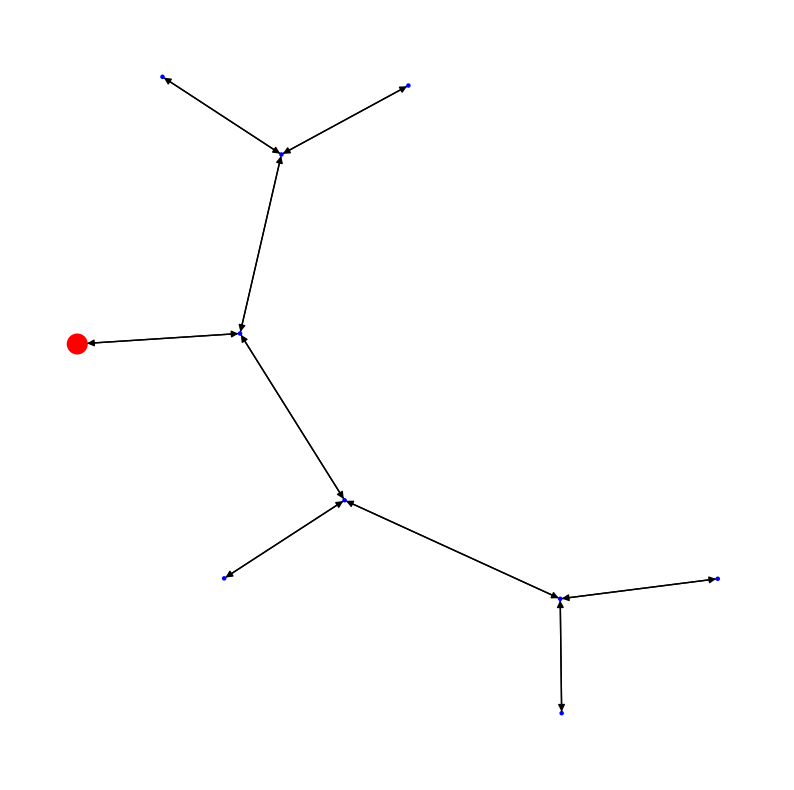

> Flux dataframe with unknowns:
        u      v direction flux_mat_i_j reverse_pair  u_popsize flux_rate    net_flux
0     S0B  A116B   forward       (0, 1)            3      556.0      r[0]  556.0*r[0]
1   A116B  A165B   forward       (1, 2)            4        1.0      r[1]    1.0*r[1]
2   A116B  A187B   forward       (1, 5)            9        1.0      r[2]    1.0*r[2]
3   A116B    S0B   reverse       (1, 0)                     1.0      r[3]    1.0*r[3]
4   A165B  A116B   reverse       (2, 1)                     1.0      r[4]    1.0*r[4]
5   A165B  A174B   forward       (2, 3)            7        1.0       0.8         0.8
6   A165B  A181B   forward       (2, 4)            8        1.0       0.8         0.8
7   A174B  A165B   reverse       (3, 2)                     1.0       0.4         0.4
8   A181B  A165B   reverse       (4, 2)                     1.0       0.4         0.4
9   A187B  A116B   reverse       (5, 1)                     1.0      r[5]    1.0*r[5]
10  A187B  A208B   for

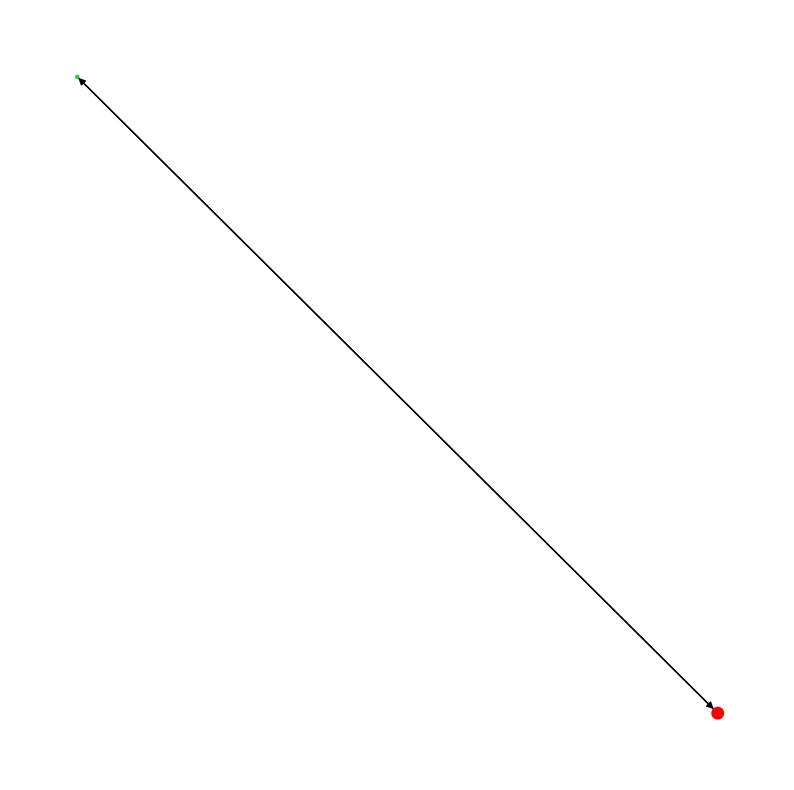

> Flux dataframe with unknowns:
       u      v direction flux_mat_i_j reverse_pair  u_popsize flux_rate    net_flux
0  D319B    S0B   reverse       (0, 1)                     8.0      r[0]    8.0*r[0]
1    S0B  D319B   forward       (1, 0)            0      556.0      r[1]  556.0*r[1]

> Net flux matrix with unknowns:
0.0        8.0*r[0]   
556.0*r[1] 0.0        

> Mass conservation constraints:
		# flux at D319B
		+(556.0*r[1]) -(8.0*r[0]) -(8.0*0.4),


> Population sum constraints:


> Net flux constraints:


> Anterograde-retrograde flux ratio constraints:
		# anterograde to retrograde net flux ratio: 1.6 <= ((r[1]*556.0)/(r[0]*8.0)) <= 2.4
		((r[1]*556.0) - (r[0]*8.0)*1.6),
		((r[0]*8.0)*2.4 - (r[1]*556.0)),


> Anterograde-retrograde population pair size constraints:


> Optimizing flux values...
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 4.44375006261303
            Iterations: 13
            Function evaluations: 57
    

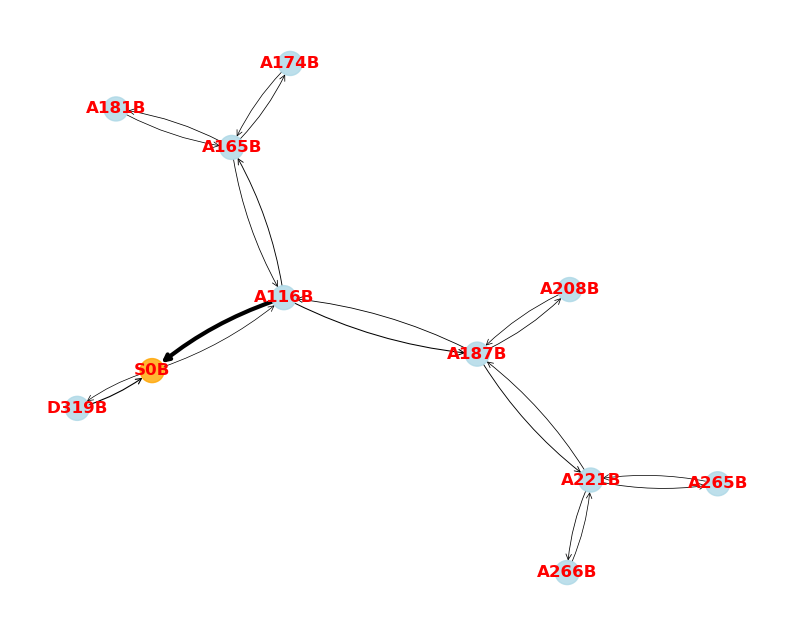

In [5]:
for subgraph_nodes in G_subgraphs:
    H = G.subgraph(subgraph_nodes)
    plot_neuron_graph(H)
    flux_dict = solve_subgraph_flux(H)
    nx.set_edge_attributes(G, flux_dict, 'rate')

plot_simulator_graph(G)    

In [6]:
TIME_POINTS = np.linspace(0, 100, 1001)
VARS, NODES = names_from_network(G)
START_STATE = start_state_from_nodes(NODES, [90,20])

>> Code for ODE model:

global ODE_model
def ODE_model(t, z):
	# variables (node name + wt/mt)
	S0B_wt, S0B_mt, A116B_wt, A116B_mt, A165B_wt, A165B_mt, A174B_wt, A174B_mt, A181B_wt, A181B_mt, A187B_wt, A187B_mt, A208B_wt, A208B_mt, A221B_wt, A221B_mt, A265B_wt, A265B_mt, A266B_wt, A266B_mt, D319B_wt, D319B_mt = z
	return [
		# ΔS0B_wt/Δt
		(S0B_wt*((3.2 + 1.0*(556-S0B_wt-(0.5*S0B_mt)))-(0.4)-(0.2)))+(A116B_wt*34.75)+(D319B_wt*4.3438),
		# ΔS0B_mt/Δt
		(S0B_mt*((3.2 + 1.0*(556-S0B_wt-(0.5*S0B_mt)))-(0.4)-(0.2)))+(A116B_mt*34.75)+(D319B_mt*4.3438),
		# ΔA116B_wt/Δt
		(A116B_wt*(0-(0.4)-(40.2323)))+(S0B_wt*0.1)+(A165B_wt*0.8566)+(A187B_wt*1.4277),
		# ΔA116B_mt/Δt
		(A116B_mt*(0-(0.4)-(40.2323)))+(S0B_mt*0.1)+(A165B_mt*0.8566)+(A187B_mt*1.4277),
		# ΔA165B_wt/Δt
		(A165B_wt*(0-(0.4)-(2.4566)))+(A116B_wt*2.0559)+(A174B_wt*0.4)+(A181B_wt*0.4),
		# ΔA165B_mt/Δt
		(A165B_mt*(0-(0.4)-(2.4566)))+(A116B_mt*2.0559)+(A174B_mt*0.4)+(A181B_mt*0.4),
		# ΔA174B_wt/Δt
		(A174B_wt*(0-(0.4)-(0.4)))+(A165

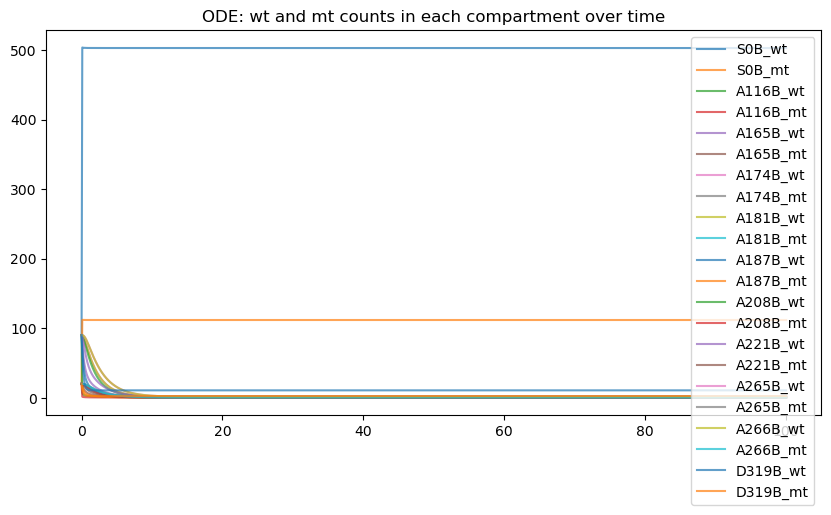

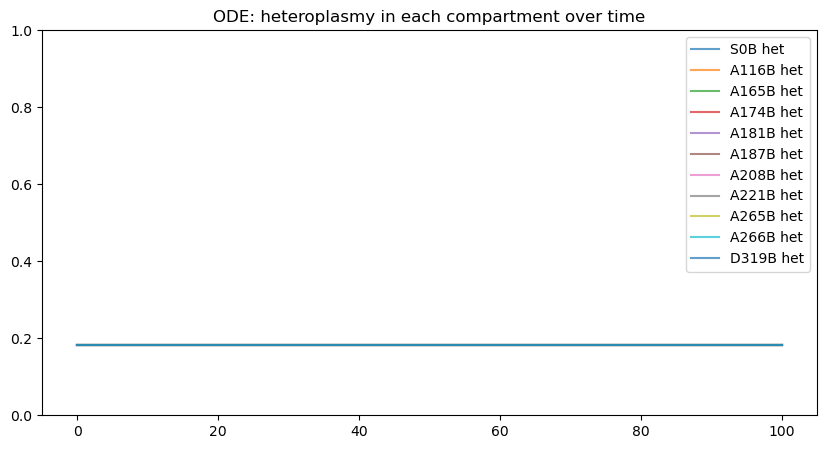

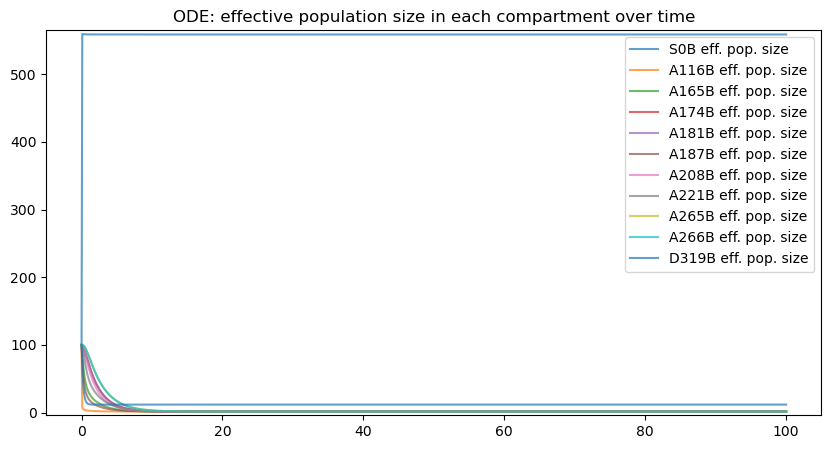

> Final counts of mt and wt in each compartment:
S0B_wt	502.904	
S0B_mt	111.7564	
A116B_wt	1.3114	
A116B_mt	0.2914	
A165B_wt	1.311	
A165B_mt	0.2913	
A174B_wt	1.311	
A174B_mt	0.2913	
A181B_wt	1.311	
A181B_mt	0.2913	
A187B_wt	1.3111	
A187B_mt	0.2913	
A208B_wt	1.3111	
A208B_mt	0.2913	
A221B_wt	1.3106	
A221B_mt	0.2912	
A265B_wt	1.3106	
A265B_mt	0.2912	
A266B_wt	1.3106	
A266B_mt	0.2912	
D319B_wt	10.6013	
D319B_mt	2.3558	

> Final effective population sizes in each compartment:
S0B	558.7822	
A116B	1.4571	
A165B	1.4566	
A174B	1.4566	
A181B	1.4566	
A187B	1.4567	
A208B	1.4567	
A221B	1.4562	
A265B	1.4562	
A266B	1.4562	
D319B	11.7792	


In [7]:
ODE_model = ODE_from_network(G, prnt=True)
plot_ODE(simulate_ode(ODE_model, TIME_POINTS, START_STATE), TIME_POINTS, DELTA, VARS, NODES)

simulating...


100%|██████████| 1000/1000 [00:05<00:00, 186.25it/s]
/home/daniel/Projects/2023_Jones_Lab_mtDNA/SSD/SSD_Neuron/plot_module.py:95: RuntimeWarning: invalid value encountered in true_divide
  het = np.nanmean(mt_counts[:,i,:]/(mt_counts[:,i,:]+wt_counts[:,i,:]), axis = 0)


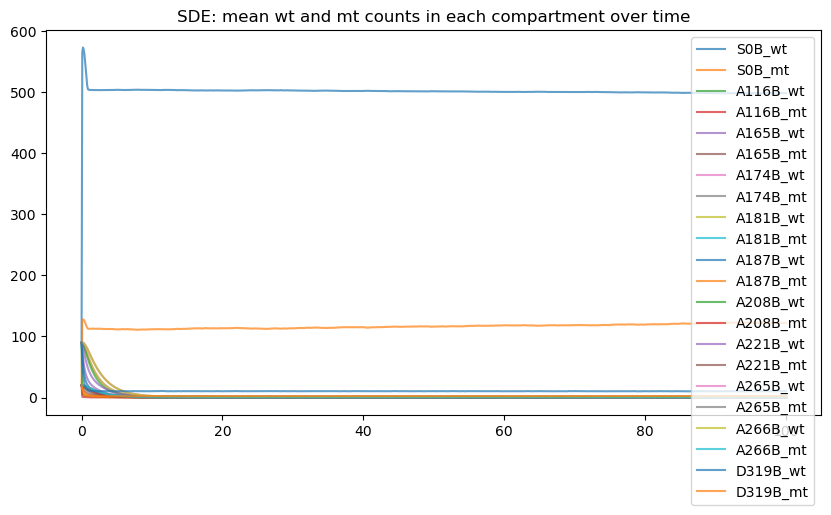

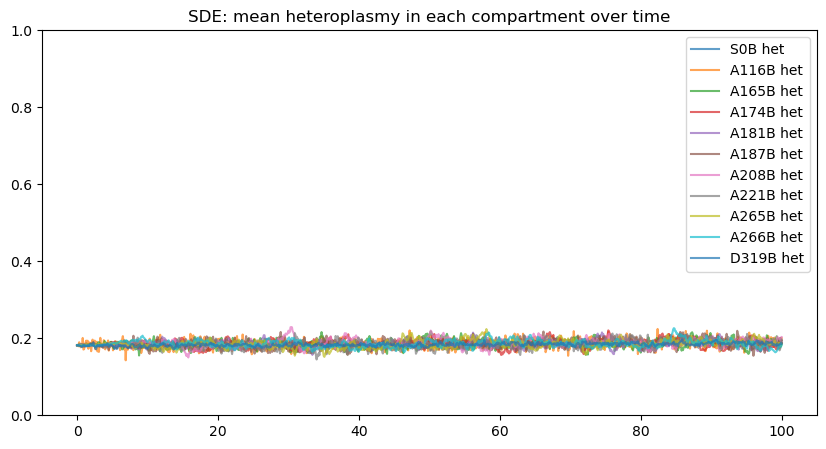

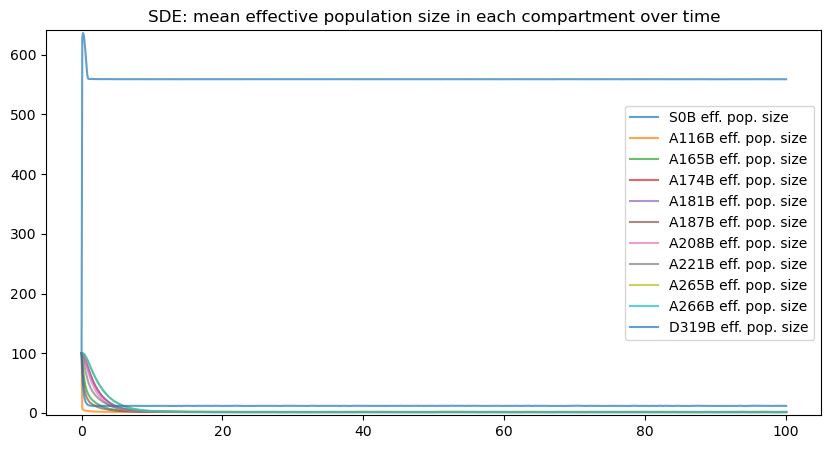

> Final mean counts of mt and wt in each compartment:
S0B_wt	497.908	
S0B_mt	122.114	
A116B_wt	1.281	
A116B_mt	0.34	
A165B_wt	1.316	
A165B_mt	0.316	
A174B_wt	1.339	
A174B_mt	0.325	
A181B_wt	1.318	
A181B_mt	0.325	
A187B_wt	1.33	
A187B_mt	0.33	
A208B_wt	1.279	
A208B_mt	0.335	
A221B_wt	1.291	
A221B_mt	0.325	
A265B_wt	1.292	
A265B_mt	0.304	
A266B_wt	1.274	
A266B_mt	0.293	
D319B_wt	10.432	
D319B_mt	2.563	

> Final mean heteroplasmy in each compartment:
S0B	0.1865	
A116B	0.2001	
A165B	0.1885	
A174B	0.1872	
A181B	0.1924	
A187B	0.1949	
A208B	0.2031	
A221B	0.1964	
A265B	0.1853	
A266B	0.1824	
D319B	0.1861	

> Final mean effective population sizes in each compartment:
S0B	558.965	
A116B	1.451	
A165B	1.474	
A174B	1.5015	
A181B	1.4805	
A187B	1.495	
A208B	1.4465	
A221B	1.4535	
A265B	1.444	
A266B	1.4205	
D319B	11.7135	

> Change in mean heteroplasmy: 
start: 0.1818
final: 0.1866
delta: 0.0047


In [8]:
GILL_PARAM = gillespie_param_from_network(G)
gillespie_results = simulate_gillespie(GILL_PARAM, TIME_POINTS, START_STATE, replicates=1000)
plot_gillespie(gillespie_results, TIME_POINTS, DELTA, VARS, NODES)